# Text Classification for the IMDB Dataset using BERT.

**Objective:** classify the IMDB Reviews into positive or negative. <br>
In this notebook we explore [BERT](https://arxiv.org/abs/1810.04805), a pre-Trained NLP model by google released in 2018. <br> 
We use the [Transfer Learning](https://towardsdatascience.com/transfer-learning-in-nlp-fecc59f546e4) procedure by loading a pre-trained BERT and refining its weights on our own textual dataset. <br>
The dataset can be downloaded from [Kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews).<br>
This notebook requires a GPU; you can use google colab if your local machine has none. <br>
**Useful documentation:** <br>
[Pytorch Pretrained Model](https://huggingface.co/transformers/v1.0.0/quickstart.html) <br>
[Pytorch DataLoader](https://pytorch.org/docs/stable/data.html) <br>
[BERT Adam Optimiser](https://huggingface.co/transformers/v1.0.0/migration.html)<br>
[Pytorch BERT For Sequence Classification](https://huggingface.co/transformers/v3.0.2/model_doc/bert.html) <br>

# Installation of needed libraries

In [3]:
# !pip install numpy==1.19.5
!pip install tensorflow==2.5.0
!pip install torch==1.9.0
# !pip install scikit-learn==0.21.3
!pip install pytorch_pretrained_bert==0.6.2 pytorch-nlp==0.5.0     
!pip install tqdm==4.41.1
# !pip install pandas==1.1.5
# !pip install matplotlib==3.2.2
!pip install beautifulsoup4==4.6.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 454.4/454.4 MB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.4/462.4 KB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 67.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.0/4.0 MB 107.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 94.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 103.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

# Importing needed libraries

In [4]:
import warnings
warnings.filterwarnings("ignore") 
import os
import numpy as np
import pickle
import tensorflow as tf



# BERT imports
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from pytorch_pretrained_bert import BertTokenizer, BertConfig
from pytorch_pretrained_bert import BertAdam, BertForSequenceClassification
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# specify GPU device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    n_gpu = torch.cuda.device_count()
    torch.cuda.get_device_name(0)

In [5]:
n_gpu

1

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
#path = "/content/drive/MyDrive/Colab Notebooks/IMDB Dataset.csv"
path = "/content/drive/MyDrive/DATA/IMDB Dataset.csv"
df = pd.read_csv(path,engine='python', error_bad_lines=False)
#df = pd.read_csv("IMDB Dataset.csv",engine='python', error_bad_lines=False)

In [9]:
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


# Exploratory Data Analysis (EDA)

In [10]:
df.isnull().sum(), set(df.sentiment)

(review       0
 sentiment    0
 dtype: int64,
 {'negative', 'positive'})

In [11]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [12]:
from sklearn.preprocessing import LabelEncoder

#sentiment is positive and negative we need to convert it to 0,1
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])

In [13]:
df['sentiment'].value_counts()

1    25000
0    25000
Name: sentiment, dtype: int64

In [14]:
#cleaning the text
from bs4 import BeautifulSoup
import re

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    text = re.sub('\[[^]]*\]', '', soup.get_text())
    pattern=r"[^a-zA-Z\s]"#r"[^a-zA-Z0-9\s,']"
    text=re.sub(pattern,'',text)
    return text

df['review']=df['review'].apply(strip)

In [15]:
strip('bhdezhhfez1235,,,,ff hbffk')

'bhdezhhfezff hbffk'

In [16]:
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,1
1,A wonderful little production The filming tech...,1
2,I thought this was a wonderful way to spend ti...,1
3,Basically theres a family where a little boy J...,0
4,Petter Matteis Love in the Time of Money is a ...,1


# Adapting our input corpus to BERT's requirements
BERT expects input data in a specific format
1. We are performing a classification task so we use a special token [CLS] to indicate this to BERT.
2. It needs to know the end of a sentence so we use the [SEP] token.

In [17]:
sentences = df['review']
sentence = ["[CLS] "+i+" [SEP]" for i in sentences]

In [18]:
sentence[0]

'[CLS] One of the other reviewers has mentioned that after watching just  Oz episode youll be hooked They are right as this is exactly what happened with meThe first thing that struck me about Oz was its brutality and unflinching scenes of violence which set in right from the word GO Trust me this is not a show for the faint hearted or timid This show pulls no punches with regards to drugs sex or violence Its is hardcore in the classic use of the wordIt is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary It focuses mainly on Emerald City an experimental section of the prison where all the cells have glass fronts and face inwards so privacy is not high on the agenda Em City is home to manyAryans Muslims gangstas Latinos Christians Italians Irish and moreso scuffles death stares dodgy dealings and shady agreements are never far awayI would say the main appeal of the show is due to the fact that it goes where other shows wouldnt dare Forget pretty p

# Tokenizing text
We need to tokenize our text into tokens that correspond to BERT’s vocabulary --> BertTokenizer

In [19]:
# Tokenize with BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Restricting the max size of Tokens to 512(BERT doest accept any more than this)
tokenized_texts = list(map(lambda t: tokenizer.tokenize(t)[:510] , sentence))
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

100%|██████████| 231508/231508 [00:00<00:00, 2733313.06B/s]


Tokenize the first sentence:
['[CLS]', 'one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', '##ll', 'be', 'hooked', 'they', 'are', 'right', 'as', 'this', 'is', 'exactly', 'what', 'happened', 'with', 'met', '##he', 'first', 'thing', 'that', 'struck', 'me', 'about', 'oz', 'was', 'its', 'brutality', 'and', 'un', '##fl', '##in', '##ching', 'scenes', 'of', 'violence', 'which', 'set', 'in', 'right', 'from', 'the', 'word', 'go', 'trust', 'me', 'this', 'is', 'not', 'a', 'show', 'for', 'the', 'faint', 'hearted', 'or', 'tim', '##id', 'this', 'show', 'pulls', 'no', 'punches', 'with', 'regards', 'to', 'drugs', 'sex', 'or', 'violence', 'its', 'is', 'hardcore', 'in', 'the', 'classic', 'use', 'of', 'the', 'word', '##it', 'is', 'called', 'oz', 'as', 'that', 'is', 'the', 'nickname', 'given', 'to', 'the', 'oswald', 'maximum', 'security', 'state', 'pen', '##ite', '##nta', '##ry', 'it', 'focuses', 'mainly', 'on', 'emerald', 'city', 'an'

# First step of vectorization: converting words into their ids using BERT vcabulary
The id of a token (word) is a sequence of integers which uniquely identify this token to this index number. <br>
Thus we call the method "convert_tokens_to_ids" of the BertTokenizer class.

In [20]:
# Set the maximum sequence length. 
MAX_LEN = 128

# Pad our input tokens so that everything has a uniform length
input_ids = list(map(tokenizer.convert_tokens_to_ids, tokenized_texts))
# or input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

print("length of sentence 0:", len(tokenized_texts[0]))
print("\nthe first 20 words of the sentence are:")
print(tokenized_texts[0][:20])
print("\nthe first 20 words of the sentence represented by their indices are:")
print(input_ids[0][:20]) 
print("\nlength of sentence 0:", len(tokenized_texts[0]), "vs length of sentence 1:", len(tokenized_texts[1]))
print("they are different!!! Hence, padding is needed!")

length of sentence 0: 332

the first 20 words of the sentence are:
['[CLS]', 'one', 'of', 'the', 'other', 'reviewers', 'has', 'mentioned', 'that', 'after', 'watching', 'just', 'oz', 'episode', 'you', '##ll', 'be', 'hooked', 'they', 'are']

the first 20 words of the sentence represented by their indices are:
[101, 2028, 1997, 1996, 2060, 15814, 2038, 3855, 2008, 2044, 3666, 2074, 11472, 2792, 2017, 3363, 2022, 13322, 2027, 2024]

length of sentence 0: 332 vs length of sentence 1: 174
they are different!!! Hence, padding is needed!


Since we are dealing with a classical ML/DL model, input dimension should always be fixed. <br>
As in a traditional ML model, the number of attributes/features/columns should be fixed, in a DL model, the input dimension should be fixed as well. <br>
In our case, the input features are sentences i.e. list of words. In order to make sure that the input has a fixed size, i.e. the sentences having the same size, we will need to fix a max length (MAX_LEN) parameter, which is the maximum number of words composing a sentence. <br>
You might ask yourselves, But every sentence has a different set of words, shouldn't we create an input size that is equal to the number of unique words in our corpus? <br>
The answer is No, because, we will never deal with words, we will deal with embeddings such that all words are embedded with vectors having the same dimension $d$ &rarr; every sentence of our corpus will be transformed into an input of size MAX_LEN $\times d$ &rarr; our input will have the same size. <br>
Thus: <br>
- sentences with number of words > than MAX_LEN will be truncated; we chose a post truncating i.e., the first MAX_LEN are retained and the remaining words are removed. 
- sentences with number of words < than MAX_LEN will be padded; we chose a post padding i.e., the 0 id will be added after the ids of the words present in the sentence.

In [21]:
input_ids = pad_sequences(input_ids,
                          maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

Let us look at a sentence with words < MAX_LEN (the sentence max length) and see what the padding does exactly.

In [22]:
for i in range(len(tokenized_texts)):
    if len(tokenized_texts[i])<30:
        print(i)

413
1417
1783
2895
3709
4304
6195
9435
9744
10973
11926
13109
13315
14420
14916
15009
18400
18424
19089
19669
19874
20053
20274
21042
24940
27521
27680
28634
28920
30598
30763
30926
30995
31072
31087
31328
31761
32935
33907
33967
34501
34692
34817
35821
36008
36088
36368
36484
39182
40038
40817
40888
41377
42319
42356
42626
43477
43607
44126
44962
45359
45373
46512
48448
48927


In [23]:
input_ids[413]

array([  101,  1037,  5790,  1997,  2515,  2025,  4088,  2000,  4671,
        2129, 10634,  2139, 24128,  1998, 21660,  2135,  2919,  2023,
        3185,  2003,   102,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [24]:
print("length of sentence 0:", len(tokenized_texts[413]))
print("\nthe first 20 words of the sentence are:")
print(tokenized_texts[413][:20])
print("\nthe first 20 words of the sentence represented by their indices are:")
print(input_ids[413][:20]) 
print("\nlength of sentence 0:", len(tokenized_texts[413]), "vs length of sentence 1:", len(input_ids[413]))
print("they are different!!! Hence, padding is needed!")

length of sentence 0: 21

the first 20 words of the sentence are:
['[CLS]', 'a', 'rating', 'of', 'does', 'not', 'begin', 'to', 'express', 'how', 'dull', 'de', '##pressing', 'and', 'relentless', '##ly', 'bad', 'this', 'movie', 'is']

the first 20 words of the sentence represented by their indices are:
[  101  1037  5790  1997  2515  2025  4088  2000  4671  2129 10634  2139
 24128  1998 21660  2135  2919  2023  3185  2003]

length of sentence 0: 21 vs length of sentence 1: 128
they are different!!! Hence, padding is needed!


In [25]:
print("After padding: \n length of sentence 0:", len(input_ids[0]), "vs length of sentence 1:", len(input_ids[1]))
print("Now all sentences have equal lengths, such that this length is the MAX_LEN variable defined by us:", MAX_LEN)

After padding: 
 length of sentence 0: 128 vs length of sentence 1: 128
Now all sentences have equal lengths, such that this length is the MAX_LEN variable defined by us: 128


# Masked Language Model (MLM)
The first task in pre-training BERT is the MLM. <br>
Words that can be masked are all words that are not padding i.e., words with id!=0

In [26]:
# Create attention masks
attention_masks = []
# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

# Training
## Split the dataset into train, validation, and test sets
1. Split the data into train (70%), validation (20%), and test (10%). 
2. Convert it to tensors. 
3. Create a data iterator using pytorch DataLoader for each of the sets.
**NB:** The code below should be changed for the split should be done twice, at two stages: <br>
1. split the dataset into train and test
2. split the train into train and validation

In [27]:
# Select a batch size for training. 
batch_size = 16
labels = list(df['sentiment'])
# Use train_test_split to split our data into train and validation sets for training
train_inputs, test_inputs, train_labels, test_labels = train_test_split(input_ids, labels,random_state=2018, test_size=0.1)
train_masks, test_masks, _, _ = train_test_split(attention_masks, input_ids,random_state=2018, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(train_masks, train_inputs,random_state=2018, test_size=0.222)
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(train_inputs, train_labels, random_state=2018, test_size=0.222)


# Convert all of our data into torch tensors, the required datatype for our model
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)
test_inputs = torch.tensor(test_inputs)
test_labels = torch.tensor(test_labels)
test_masks = torch.tensor(test_masks)


# Create an iterator of our data with torch DataLoader 
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)
...

Ellipsis

## Loading pre trained BERT
Since our problem is a classification one, we will load the BERT model that was fine-tuned for a similar classification task. <br>
Pytorch has fine-tuned BERT for several tasks: for BertForMultipleChoice,  BertForSequenceClassification, etc. <br>
In our case, we do a classification, thus we will use BertForSequenceClassification.

In [28]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)#binary classification
if torch.cuda.is_available():
    print(model.cuda())
else:
    print(model)

100%|██████████| 407873900/407873900 [00:06<00:00, 63501922.65B/s]


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1, inplace=False)
   

# Fine-Tuning BERT with our specific task
The training could take around an hour and a half to run on Colab with a GPU.

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.41222785792431366


Epoch:  25%|██▌       | 1/4 [20:43<1:02:09, 1243.22s/it]

Validation Accuracy: 0.8669
Train loss: 0.25239226835460327


Epoch:  50%|█████     | 2/4 [41:28<41:27, 1243.96s/it]  

Validation Accuracy: 0.8732333333333334
Train loss: 0.16126237537728025


Epoch:  75%|███████▌  | 3/4 [1:02:09<20:42, 1242.82s/it]

Validation Accuracy: 0.8634333333333334
Train loss: 0.09496407913477635


Epoch: 100%|██████████| 4/4 [1:22:47<00:00, 1241.97s/it]

Validation Accuracy: 0.8605333333333334


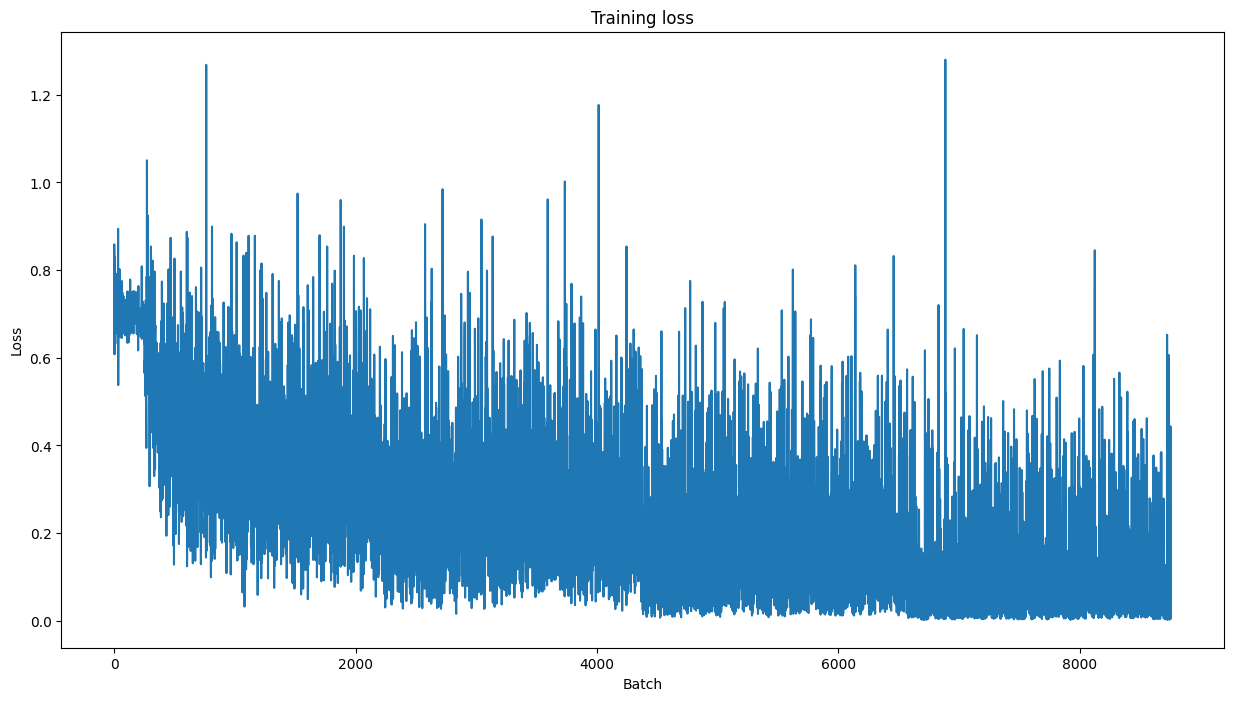

In [29]:
# BERT fine-tuning parameters
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01}, # either 1 lr for all epochs, either adapt lr:weight decay
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

optimizer = BertAdam(#model.parameters(),#
                     optimizer_grouped_parameters,
                     lr=2e-5,
                     warmup=.1)

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten() # Returns the indices of the maximum values along an axis.
    labels_flat = labels.flatten()# Converts an N dimensional array to a 1D array
    return np.sum(pred_flat == labels_flat) / len(labels_flat) # accuracy

torch.cuda.empty_cache() 
# Store our loss and accuracy for plotting
train_loss_set = []
# Number of training epochs 
epochs = 4

# BERT training loop
for _ in trange(epochs, desc="Epoch"):  
  
  ## TRAINING
  
  # Set our model to training mode
    model.train()  
  # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
  # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
      # Forward pass
      #https://huggingface.co/transformers/v3.0.2/model_doc/bert.html
        loss = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        train_loss_set.append(loss.item())    
      # Backward pass
        loss.backward()
      # Update parameters and take a step using the computed gradient
        optimizer.step()
      # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
    print("Train loss: {}".format(tr_loss/nb_tr_steps))
       
  ## VALIDATION

  # Put model in evaluation mode
    model.eval() #exclude batch nor and drop out
  # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0
  # Evaluate data for one epoch
    for batch in validation_dataloader:
      # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
      # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
      # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
        # Forward pass, calculate logit predictions
          logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
      # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

# plot training performance
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

## Test the model on the test set

In [30]:
...

Ellipsis

In [31]:
# Put model in evaluation mode
model.eval()
# Tracking variables 
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for batch_test in test_dataloader:
      # Add batch to GPU
  batch_test = tuple(t.to(device) for t in batch_test)
      # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch_test
      # Telling the model not to compute or store gradients, saving memory and speeding up validation
  with torch.no_grad():
        # Forward pass, calculate logit predictions
    logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)    
      # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  tmp_eval_accuracy = flat_accuracy(logits, label_ids)    
  eval_accuracy += tmp_eval_accuracy
  nb_eval_steps += 1
print("Test Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Test Accuracy: 0.8616214057507987
